# 1. Table extraction

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
from esg_data_pipeline import PDFTableExtractor
from esg_data_pipeline import config

In [3]:
PDFTableExtractor_kwargs = {
    "batch_size": -1,
    "cscdtabnet_config": config.CONFIG_FOLDER / "cascade_mask_rcnn_hrnetv2p_w32_20e.py",
    "cscdtabnet_ckpt": config.CHECKPOINT_FOLDER / "icdar_19b2.pth",
    "bbox_thres": .85,
    "dpi": 200
}

In [5]:
table_extractor = PDFTableExtractor(**PDFTableExtractor_kwargs)

2020-07-23 21:18:08,734 — esg_data_pipeline.components.pdf_table_extractor — INFO —__create_model:58 — cascadetabnet checkpoint does not exist. Downloading...


Downloading...
From: https://drive.google.com/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT
To: /esg_data_pipeline/esg_data_pipeline/checkpoint/icdar_19b2.pth
664MB [00:14, 45.5MB/s] 


### Extract tables from a single pdf file
Table Extraction happens in two stages:
1. **Infer Bounding Box:** Convert a pdf into image and use an object detection model for table recognition. The model is called CascadeTabNet. The output of this stage is the coordinates of tables.

2. **Extract tables:** from PDFs using Tabula. The coordinates are passed to tabula for analyzing that area of page.

In [6]:
pdf_path = config.DATA_FOLDER / "final_combined.pdf"

### 1. Infer Bounding Box

In [7]:
from pdf2image import convert_from_path, pdfinfo_from_path
images = convert_from_path(
                pdf_path,
                first_page=1,
                last_page=20,
                use_pdftocairo=True,
                dpi=PDFTableExtractor_kwargs["dpi"])

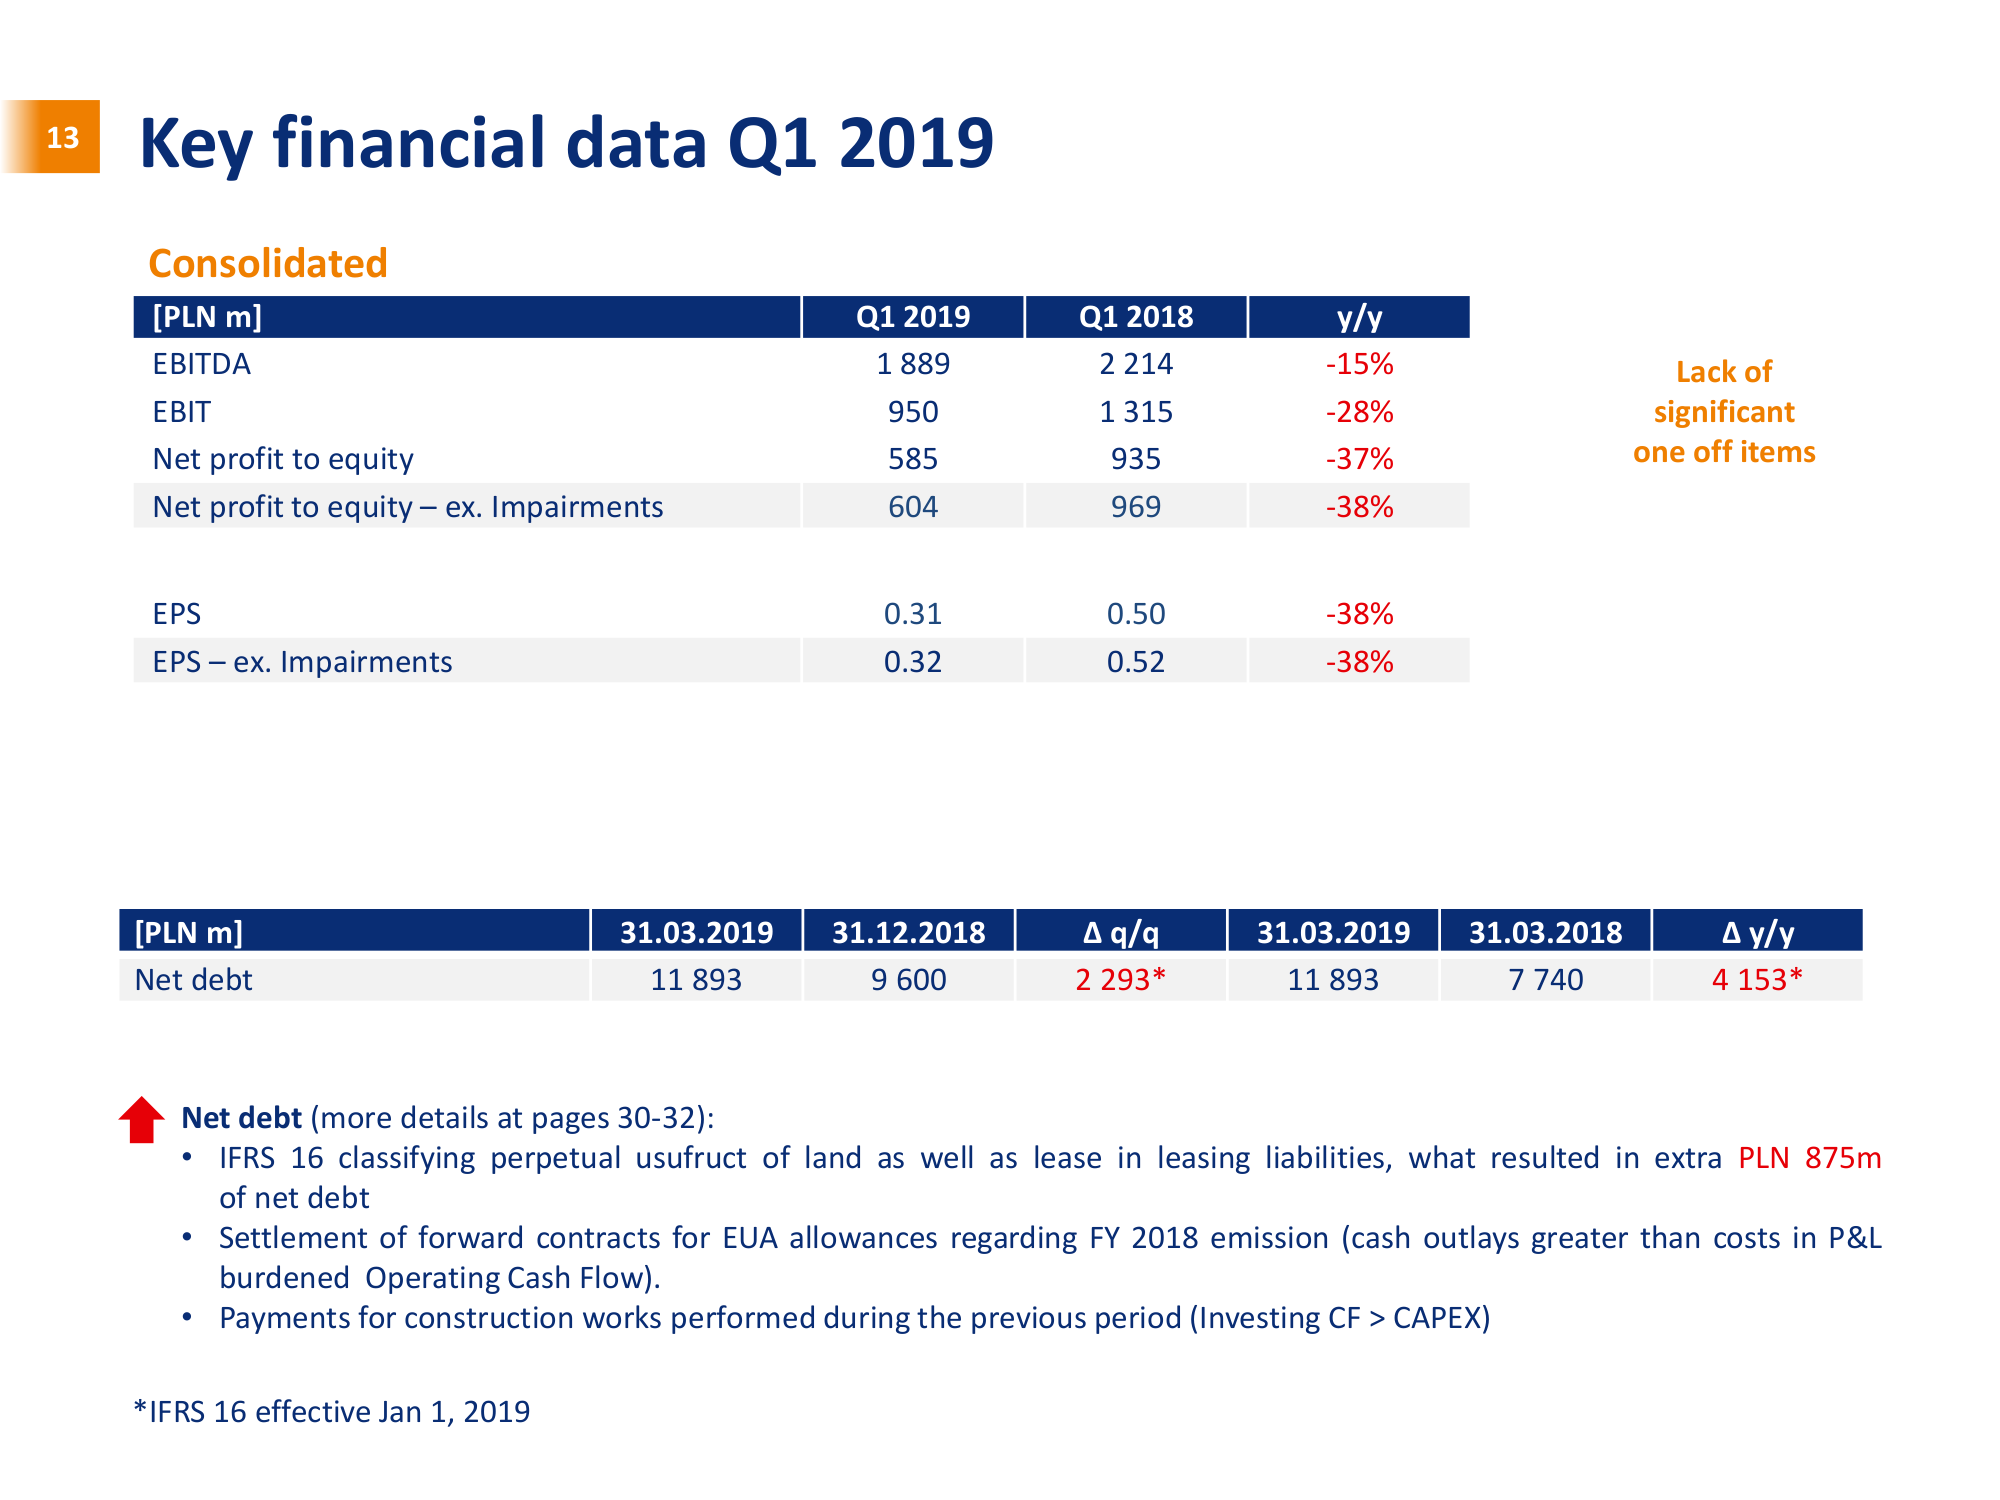

In [8]:
page_num = 3
images[page_num]

In [9]:
import numpy as np
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
temp = inference_detector(table_extractor.model, np.array(images[page_num]))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [10]:
print ("Coordinates and probabilities of bordered tables\n", (temp[0][0]))
print ("Coordinates and probabilities of borderless tables\n", (temp[0][2]))

Coordinates and probabilities of bordered tables
 []
Coordinates and probabilities of borderless tables
 [[1.18381516e+02 2.91443512e+02 1.57741553e+03 6.94924866e+02
  9.98581409e-01]
 [1.40852097e+02 9.03176086e+02 1.85584314e+03 9.85421814e+02
  2.33963147e-01]]


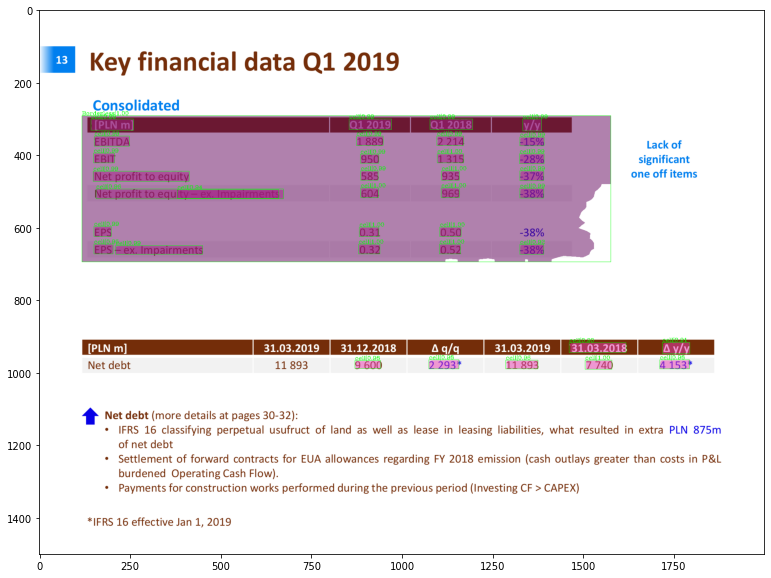

In [11]:
show_result_pyplot(
    np.array(images[page_num]), 
    temp,
    ('Bordered', 'cell', 'Borderless'), 
    score_thr=PDFTableExtractor_kwargs["bbox_thres"]
)

These steps are encapsulated in a single function in PDFTableExtractor, `infer_bbox()`

In [15]:
# Infer bbox for each page
table_coords = table_extractor.infer_bbox(pdf_path)

Inferring tables for page 1-21:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))

Page:  95%|█████████▌| 20/21 [00:32<00:01,  1.65s/it]
Inferring tables for page 21-41: 0it [00:00, ?it/s]
Page: 40it [00:50,  1.16s/it]                        

### 2. Extract Table using Tabula

`extract_table()` extracts tables using Tabula and saves them as csv in the extraction folder

In [18]:
tables, tables_meta = table_extractor.extract_table(pdf_path, table_coords, config.EXTRACTION_FOLDER, None)


Extracting and saving tables: 100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


In [20]:
tables[page_num+1][0]

,0,1,2,3
0,[PLN m],Q1 2019,Q1 2018,y/y
1,EBITDA,1 889,2 214,-15%
2,EBIT,950,1 315,-28%
3,Net profit to equity,585,935,-37%
4,Net profit to equity – ex. Impairments,604,969,-38%
5,EPS,0.31,0.50,-38%
6,EPS – ex. Impairments,0.32,0.52,-38%


In [21]:
!ls $config.EXTRACTION_FOLDER

final_combined_page10_1.csv  final_combined_page17_5.csv
final_combined_page11_1.csv  final_combined_page18_1.csv
final_combined_page11_2.csv  final_combined_page19_1.csv
final_combined_page11_3.csv  final_combined_page19_2.csv
final_combined_page12_1.csv  final_combined_page1_1.csv
final_combined_page12_2.csv  final_combined_page20_1.csv
final_combined_page12_3.csv  final_combined_page20_2.csv
final_combined_page13_1.csv  final_combined_page20_3.csv
final_combined_page13_2.csv  final_combined_page2_1.csv
final_combined_page14_1.csv  final_combined_page3_1.csv
final_combined_page15_1.csv  final_combined_page3_2.csv
final_combined_page16_1.csv  final_combined_page4_1.csv
final_combined_page16_2.csv  final_combined_page6_1.csv
final_combined_page17_1.csv  final_combined_page7_1.csv
final_combined_page17_2.csv  final_combined_page8_1.csv
final_combined_page17_3.csv  final_combined_page9_1.csv
final_combined_page17_4.csv  final_combined_page9_2.csv


## Automate these processes using run_folder() function

We extract all tables from pdfs in the `data/pdfs` folder. First, let's delete all files in the extraction folder. In the pdfs folder, we have both `2015_BASF_Report.pdf` and `cez-annual-report-2018.pdf`.

In [25]:
!rm -rf $config.EXTRACTION_FOLDER/*

In [26]:
!ls $config.EXTRACTION_FOLDER

This whole process will take approximately 15-20min due to 

In [27]:
table_extractor.run_folder(config.PDF_FOLDER, config.EXTRACTION_FOLDER)

2020-07-23 21:50:57,352 — esg_data_pipeline.components.pdf_table_extractor — INFO —run:221 — PDFTableExtractor is running on file /esg_data_pipeline/esg_data_pipeline/data/pdfs/cez-en-annual-report-2018.pdf...




Page:   0%|          | 0/9 [00:00<?, ?it/s]


Inferring tables for page 1-9:   0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Inferring tables for page 1-9:  12%|█▎        | 1/8 [00:00<00:01,  5.72it/s]


Inferring tables for page 1-9:  25%|██▌       | 2/8 [00:00<00:01,  4.42it/s]


Inferring tables for page 1-9:  38%|███▊      | 3/8 [00:00<00:01,  4.79it/s]


Inferring tables for page 1-9:  50%|█████     | 4/8 [00:00<00:00,  4.72it/s]


Inferring tables for page 1-9:  62%|██████▎   | 5/8 [00:01<00:00,  4.79it/s]


Inferring tables for page 1-9:  75%|███████▌  | 6/8 [00:01<00:00,  4.98it/s]


Inferring tables for page 1-9:  88%|████████▊ | 

2020-07-23 21:51:10,519 — esg_data_pipeline.components.pdf_table_extractor — INFO —run:221 — PDFTableExtractor is running on file /esg_data_pipeline/esg_data_pipeline/data/pdfs/2015_BASF_Report.pdf...






Page:   0%|          | 0/263 [00:00<?, ?it/s]

Page: 16it [00:26,  1.42it/s]



Inferring tables for page 1-263:   0%|          | 0/262 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))




Inferring tables for page 1-263:   0%|          | 1/262 [00:00<01:07,  3.89it/s]



Inferring tables for page 1-263:   1%|          | 2/262 [00:01<02:37,  1.65it/s]



Inferring tables for page 1-263:   1%|          | 3/262 [00:02<03:11,  1.35it/s]



Inferring tables for page 1-263:   2%|▏         | 4/262 [00:03<03:20,  1.28it/s]



Inferring tables for page 1-263:   2%|▏         | 5/262 [00:04<02:55,  1.46it/s]



Inferring tables for page 1-263:   2%|▏         | 6/262 [00:0

Inferring tables for page 1-263:  30%|███       | 79/262 [00:30<02:03,  1.48it/s]



Inferring tables for page 1-263:  31%|███       | 80/262 [00:31<01:40,  1.82it/s]



Inferring tables for page 1-263:  31%|███       | 81/262 [00:32<01:58,  1.53it/s]



Inferring tables for page 1-263:  31%|███▏      | 82/262 [00:32<01:58,  1.52it/s]



Inferring tables for page 1-263:  32%|███▏      | 83/262 [00:33<01:55,  1.55it/s]



Inferring tables for page 1-263:  32%|███▏      | 84/262 [00:33<01:42,  1.73it/s]



Inferring tables for page 1-263:  32%|███▏      | 85/262 [00:34<01:43,  1.71it/s]



Inferring tables for page 1-263:  33%|███▎      | 86/262 [00:34<01:26,  2.03it/s]



Inferring tables for page 1-263:  33%|███▎      | 87/262 [00:35<01:33,  1.87it/s]



Inferring tables for page 1-263:  34%|███▎      | 88/262 [00:35<01:34,  1.85it/s]



Inferring tables for page 1-263:  34%|███▍      | 89/262 [00:36<01:35,  1.82it/s]



Inferring tables for page 1-263:  34%|███▍      | 90/262 [00:36<0

Inferring tables for page 1-263:  62%|██████▏   | 162/262 [01:02<01:01,  1.62it/s]



Inferring tables for page 1-263:  62%|██████▏   | 163/262 [01:03<01:13,  1.34it/s]



Inferring tables for page 1-263:  63%|██████▎   | 164/262 [01:03<00:55,  1.75it/s]



Inferring tables for page 1-263:  63%|██████▎   | 165/262 [01:03<00:43,  2.23it/s]



Inferring tables for page 1-263:  63%|██████▎   | 166/262 [01:03<00:35,  2.72it/s]



Inferring tables for page 1-263:  64%|██████▎   | 167/262 [01:03<00:29,  3.26it/s]



Inferring tables for page 1-263:  64%|██████▍   | 168/262 [01:04<00:25,  3.72it/s]



Inferring tables for page 1-263:  65%|██████▍   | 169/262 [01:04<00:42,  2.18it/s]



Inferring tables for page 1-263:  65%|██████▍   | 170/262 [01:05<00:33,  2.71it/s]



Inferring tables for page 1-263:  65%|██████▌   | 171/262 [01:05<00:31,  2.85it/s]



Inferring tables for page 1-263:  66%|██████▌   | 172/262 [01:05<00:26,  3.41it/s]



Inferring tables for page 1-263:  66%|██████▌   | 173/

Inferring tables for page 1-263:  94%|█████████▎| 245/262 [01:45<00:10,  1.55it/s]



Inferring tables for page 1-263:  94%|█████████▍| 246/262 [01:46<00:09,  1.66it/s]



Inferring tables for page 1-263:  94%|█████████▍| 247/262 [01:47<00:10,  1.38it/s]



Inferring tables for page 1-263:  95%|█████████▍| 248/262 [01:48<00:11,  1.25it/s]



Inferring tables for page 1-263:  95%|█████████▌| 249/262 [01:48<00:08,  1.57it/s]



Inferring tables for page 1-263:  95%|█████████▌| 250/262 [01:48<00:05,  2.01it/s]



Inferring tables for page 1-263:  96%|█████████▌| 251/262 [01:50<00:07,  1.45it/s]



Inferring tables for page 1-263:  96%|█████████▌| 252/262 [01:51<00:08,  1.20it/s]



Inferring tables for page 1-263:  97%|█████████▋| 253/262 [01:51<00:07,  1.22it/s]



Inferring tables for page 1-263:  97%|█████████▋| 254/262 [01:52<00:04,  1.60it/s]



Inferring tables for page 1-263:  97%|█████████▋| 255/262 [01:52<00:03,  2.02it/s]



Inferring tables for page 1-263:  98%|█████████▊| 256/

Extracting and saving tables:  42%|████▏     | 65/154 [05:23<05:04,  3.42s/it]



Extracting and saving tables:  43%|████▎     | 66/154 [05:26<04:53,  3.33s/it]



Extracting and saving tables:  44%|████▎     | 67/154 [05:29<04:43,  3.26s/it]



Extracting and saving tables:  44%|████▍     | 68/154 [05:35<05:55,  4.13s/it]



Extracting and saving tables:  45%|████▍     | 69/154 [05:38<05:24,  3.82s/it]



Extracting and saving tables:  45%|████▌     | 70/154 [05:41<05:01,  3.59s/it]



Extracting and saving tables:  46%|████▌     | 71/154 [05:50<07:21,  5.32s/it]



Extracting and saving tables:  47%|████▋     | 72/154 [05:53<06:20,  4.65s/it]



Extracting and saving tables:  47%|████▋     | 73/154 [05:56<05:36,  4.16s/it]



Extracting and saving tables:  48%|████▊     | 74/154 [05:59<05:04,  3.81s/it]



Extracting and saving tables:  49%|████▊     | 75/154 [06:03<04:44,  3.61s/it]



Extracting and saving tables:  49%|████▉     | 76/154 [06:09<05:42,  4.39s/it]



Extracting and s

Extracting and saving tables:  98%|█████████▊| 151/154 [13:08<00:14,  4.88s/it]



Extracting and saving tables:  99%|█████████▊| 152/154 [13:11<00:08,  4.38s/it]



Extracting and saving tables:  99%|█████████▉| 153/154 [13:14<00:04,  4.02s/it]



Extracting and saving tables: 100%|██████████| 154/154 [13:17<00:00,  5.18s/it]


In [28]:
!ls $config.EXTRACTION_FOLDER

2015_BASF_Report_page100_1.csv	2015_BASF_Report_page233_3.csv
2015_BASF_Report_page101_1.csv	2015_BASF_Report_page234_1.csv
2015_BASF_Report_page102_1.csv	2015_BASF_Report_page235_1.csv
2015_BASF_Report_page103_1.csv	2015_BASF_Report_page235_2.csv
2015_BASF_Report_page103_2.csv	2015_BASF_Report_page236_1.csv
2015_BASF_Report_page105_1.csv	2015_BASF_Report_page236_2.csv
2015_BASF_Report_page106_1.csv	2015_BASF_Report_page236_3.csv
2015_BASF_Report_page108_1.csv	2015_BASF_Report_page236_4.csv
2015_BASF_Report_page110_1.csv	2015_BASF_Report_page237_1.csv
2015_BASF_Report_page114_1.csv	2015_BASF_Report_page241_1.csv
2015_BASF_Report_page116_1.csv	2015_BASF_Report_page241_2.csv
2015_BASF_Report_page117_1.csv	2015_BASF_Report_page242_1.csv
2015_BASF_Report_page117_2.csv	2015_BASF_Report_page242_2.csv
2015_BASF_Report_page119_1.csv	2015_BASF_Report_page243_1.csv
2015_BASF_Report_page122_1.csv	2015_BASF_Report_page243_2.csv
2015_BASF_Report_page124_1.csv	2015_BASF_Report_page244_1.csv
2015_BAS

Notice that there is a `table_meta.json` which contains the corresponding table csv files for each page of each pdf file.

# 2. Table Curation

 We focus on the tables extracted from `2015_BASF_Report.pdf` and will be using Allyson's annotations on this report.

In [30]:
from esg_data_pipeline import TableCurator

In [31]:
tb_cur = TableCurator(neg_pos_ratio=1, create_neg_samples=True)

In [32]:
tb_cur.run(config.EXTRACTION_FOLDER, config.ANNOTATION_FOLDER, config.CURATION_FOLDER)

2020-07-23 22:19:18,034 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 21.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,036 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 22.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,037 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 23.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,038 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 24.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,039 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 21.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,040 — esg_data_pipeline.components.table_curator — WARNING —create_pos_examples:99 — 22.0 is not a valid kpi id. Skipping this example...
2020-07-23 22:19:18,041 — esg_data_pipeline.componen

2020-07-23 22:19:18,100 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,101 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,102 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,103 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,104 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,105 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — BASF_Report_2017.pdf do

2020-07-23 22:19:18,144 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Wintershall-Dea_Sustainability_Report_2019.pdf does not exist in table_meta.json
2020-07-23 22:19:18,145 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Wintershall-Dea_Sustainability_Report_2019.pdf does not exist in table_meta.json
2020-07-23 22:19:18,146 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Wintershall-Dea_Sustainability_Report_2019.pdf does not exist in table_meta.json
2020-07-23 22:19:18,147 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Wintershall-Dea_Sustainability_Report_2019.pdf does not exist in table_meta.json
2020-07-23 22:19:18,148 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — annual 2018.pdf does not exist in table_meta.json
2020-07-23 22:19:18,148 — esg_data_pipeli

2020-07-23 22:19:18,185 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Aker-BP-Annual-report-2018.pdf does not exist in table_meta.json
2020-07-23 22:19:18,186 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Aker-BP-Annual-report-2018.pdf does not exist in table_meta.json
2020-07-23 22:19:18,187 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — Aker-BP-Annual-report-2018.pdf does not exist in table_meta.json
2020-07-23 22:19:18,188 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — AKERBP-Annual-Report-2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,189 — esg_data_pipeline.components.table_curator — WARNING —process_single_annotation_file:262 — AKERBP-Annual-Report-2017.pdf does not exist in table_meta.json
2020-07-23 22:19:18,190 — esg_data_pipeline.components.table_curator — WARNING —process_sing

Most of the warnings are just pdfs which do not exist in `table_meta.json`, in other words do not exist in the initial pdfs folder. Next, we will see that the curation folder will have a csv which shows the curated data.

In [33]:
!ls $config.CURATION_FOLDER

esg_table_dataset.csv


In [34]:
import pandas as pd
df = pd.read_csv(config.CURATION_FOLDER / "esg_table_dataset.csv", index_col=0)

In [35]:
df

,Company,Year,Question,Answer,Table_filename,Label
0,BASF SE,2015,What is the total volume of crude oil liquid p...,NaN,2015_BASF_Report_page208_1.csv,0
1,BASF SE,2015,What is the total volume of crude oil liquid p...,41 million barrels (MMbbl),2015_BASF_Report_page242_1.csv,1
2,BASF SE,2015,What is the total volume of natural gas produc...,NaN,2015_BASF_Report_page30_1.csv,0
3,BASF SE,2015,What is the total volume of natural gas produc...,632 billion standard cubic feet (BSCF),2015_BASF_Report_page242_2.csv,1
4,BASF SE,2014,What is the total volume of crude oil liquid p...,NaN,2015_BASF_Report_page93_2.csv,0
5,BASF SE,2014,What is the total volume of crude oil liquid p...,31 million barrels (MMbbl),2015_BASF_Report_page243_1.csv,1
6,BASF SE,2014,What is the total volume of natural gas produc...,NaN,2015_BASF_Report_page203_2.csv,0
7,BASF SE,2014,What is the total volume of natural gas produc...,590 billion standard cubic feet (BSCF),2015_BASF_Report_page243_2.csv,1
8,BASF SE,2015,What is the total amount of energy indirect gr...,NaN,2015_BASF_Report_page5_1.csv,0
9,BASF SE,2015,What is the total amount of energy indirect gr...,"3,795 1,000 metric tons of CO2 equivalents",2015_BASF_Report_page122_1.csv,1
